# Chapter 9

Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [2]:
import numpy as np

import random

import thinkstats2
import thinkplot

## Hypothesis testing

The following is a version of `thinkstats2.HypothesisTest` with just the essential methods:

In [3]:
class HypothesisTest(object):

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()

And here's an example that uses it to compute the p-value of an experiment where we toss a coin 250 times and get 140 heads.

In [4]:
class CoinTest(HypothesisTest):

    def TestStatistic(self, data):
        heads, tails = data
        test_stat = abs(heads - tails)
        return test_stat

    def RunModel(self):
        heads, tails = self.data
        n = heads + tails
        sample = [random.choice('HT') for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist['H'], hist['T']
        return data

The p-value turns out to be about 7%, which is considered on the border of statistical significance.

In [5]:
ct = CoinTest((140, 110))
pvalue = ct.PValue()
pvalue

0.064

## Permutation test

To compute the p-value of an observed difference in means, we can assume that there is no difference between the groups and generate simulated results by shuffling the data.

In [6]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

Here's an example where we test the observed difference in pregnancy length for first babies and others.

In [7]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [8]:
import first

live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

c:\Users\champ\OneDrive\Documents\DSC530 Data Exploration\ThinkStats2\code\nsfg.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.birthwgt_lb.replace(na_vals, np.nan, inplace=True)
c:\Users\champ\OneDrive\Documents\DSC530 Data Exploration\ThinkStats2\code\nsfg.py:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are sett

The p-value is about 17%, which means it is plausible that the observed difference is just the result of random sampling, and might not be generally true in the population.

In [9]:
ht = DiffMeansPermute(data)
pvalue = ht.PValue()
pvalue

0.19

Here's the distrubution of the test statistic (the difference in means) over many simulated samples:

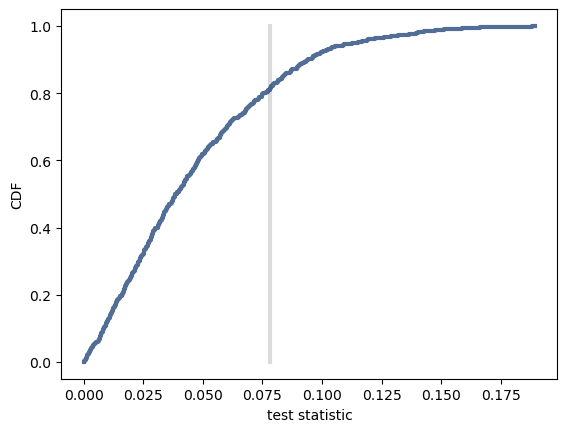

In [10]:
ht.PlotCdf()
thinkplot.Config(xlabel='test statistic',
                   ylabel='CDF')

Under the null hypothesis, we often see differences bigger than the observed difference.

In [11]:
class DiffMeansOneSided(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.mean() - group2.mean()
        return test_stat

If the hypothesis under test is that first babies come late, the appropriate test statistic is the raw difference between first babies and others, rather than the absolute value of the difference.  In that case, the p-value is smaller, because we are testing a more specific hypothesis.

In [12]:
ht = DiffMeansOneSided(data)
pvalue = ht.PValue()
pvalue

0.081

But in this example, the result is still not statistically significant.

## Difference in standard deviation

In this framework, it is easy to use other test statistics.  For example, if we think the variance for first babies might be higher, we can run this test:

In [13]:
class DiffStdPermute(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat

In [14]:
ht = DiffStdPermute(data)
pvalue = ht.PValue()
pvalue

0.089

But that's not statistically significant either.

## Testing correlation

To check whether an observed correlation is statistically significant, we can run a permutation test with a different test statistic.

In [15]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

Here's an example testing the correlation between birth weight and mother's age.

In [16]:
cleaned = live.dropna(subset=['agepreg', 'totalwgt_lb'])
data = cleaned.agepreg.values, cleaned.totalwgt_lb.values
ht = CorrelationPermute(data)
pvalue = ht.PValue()
pvalue

0.0

The reported p-value is 0, which means that in 1000 trials we didn't see a correlation, under the null hypothesis, that exceeded the observed correlation.  That means that the p-value is probably smaller than $1/1000$, but it is not actually 0.

To get a sense of how unexpected the observed value is under the null hypothesis, we can compare the actual correlation to the largest value we saw in the simulations.

In [17]:
ht.actual, ht.MaxTestStat()

(0.06883397035410908, 0.032870240904117894)

## Testing proportions

Here's an example that tests whether the outcome of a rolling a six-sided die is suspicious, where the test statistic is the total absolute difference between the observed outcomes and the expected long-term averages.

In [18]:
class DiceTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum(abs(observed - expected))
        return test_stat

    def RunModel(self):
        n = sum(self.data)
        values = [1, 2, 3, 4, 5, 6]
        rolls = np.random.choice(values, n, replace=True)
        hist = thinkstats2.Hist(rolls)
        freqs = hist.Freqs(values)
        return freqs

Here's an example using the data from the book:

In [19]:
data = [8, 9, 19, 5, 8, 11]
dt = DiceTest(data)
pvalue = dt.PValue(iters=10000)
pvalue

0.1257

The observed deviance from the expected values is not statistically significant.

By convention, it is more common to test data like this using the chi-squared statistic:

In [20]:
class DiceChiTest(DiceTest):

    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum((observed - expected)**2 / expected)
        return test_stat

Using this test, we get a smaller p-value:

In [21]:
dt = DiceChiTest(data)
pvalue = dt.PValue(iters=10000)
pvalue

0.0364

Taking this result at face value, we might consider the data statistically significant, but considering the results of both tests, I would not draw any strong conclusions.

## Chi-square test of pregnancy length

In [22]:
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

If we specifically test the deviations of first babies and others from the expected number of births in each week of pregnancy, the results are statistically significant with a very small p-value.  But at this point we have run so many tests, we should not be surprised to find at least one that seems significant.

In [23]:
data = firsts.prglngth.values, others.prglngth.values
ht = PregLengthTest(data)
p_value = ht.PValue()
print('p-value =', p_value)
print('actual =', ht.actual)
print('ts max =', ht.MaxTestStat())

p-value = 0.0
actual = 101.50141482893264
ts max = 33.107448431065635


## Power

Here's the function that estimates the probability of a non-significant p-value even is there really is a difference between the groups.

In [24]:
def FalseNegRate(data, num_runs=1000):
    """Computes the chance of a false negative based on resampling.

    data: pair of sequences
    num_runs: how many experiments to simulate

    returns: float false negative rate
    """
    group1, group2 = data
    count = 0

    for i in range(num_runs):
        sample1 = thinkstats2.Resample(group1)
        sample2 = thinkstats2.Resample(group2)
        ht = DiffMeansPermute((sample1, sample2))
        p_value = ht.PValue(iters=101)
        if p_value > 0.05:
            count += 1

    return count / num_runs

In [25]:
neg_rate = FalseNegRate(data)
neg_rate

0.7

In this example, the false negative rate is 70%, which means that the power of the test (probability of statistical significance if the actual difference is 0.078 weeks) is only 30%.

## Exercises

**Exercise:** As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use `thinkstats2.SampleRows` to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [47]:
import thinkstats2
import nsfg  # Load the dataset
import pandas as pd
import scipy.stats as stats

# Load NSFG dataset
df = nsfg.ReadFemPreg()

# Clean the dataset by dropping rows with NaN or infinite values in 'prglngth' or 'birthwgt_lb'
df = df.replace([float('inf'), -float('inf')], pd.NA).dropna(subset=['prglngth', 'birthwgt_lb'])

# Get the actual available sample size
max_available = len(df)

# Function to run t-test and correlation test on a subset of data
def run_tests(sample_size):
    actual_size = min(sample_size, max_available)  # Ensure we don't sample more than available
    subset = thinkstats2.SampleRows(df, actual_size)  # Randomly sample actual_size rows
    
    # t-Test (Parametric) comparing subset to full dataset
    t_stat, t_p_value = stats.ttest_ind(subset['prglngth'], df['prglngth'], equal_var=False)
    
    # Pearson Correlation within the subset
    if len(subset) > 1 and not subset['birthwgt_lb'].isnull().all():  # Correlation requires at least 2 valid values
        corr_coeff, corr_p_value = stats.pearsonr(subset['prglngth'], subset['birthwgt_lb'])
    else:
        corr_coeff, corr_p_value = float('nan'), float('nan')  # Handle small or invalid sample sizes
    
    return t_p_value, abs(t_stat), corr_p_value, abs(corr_coeff)

# Sample sizes to test (ensure they don't exceed max_available)
sample_sizes = [s for s in [9148, 4574, 2287, 1143, 571, 285, 142] if s <= max_available]
results = {n: run_tests(n) for n in sample_sizes}

# Print results
print("means permute preglength")
print(f"p-value = {results[sample_sizes[0]][0]:.4f}")
print(f"actual = {results[sample_sizes[0]][1]}")
print(f"ts max = {max(result[1] for result in results.values() if not pd.isna(result[1]))}\n")

print("means permute birthweight")
print(f"p-value = {results[sample_sizes[0]][2]:.4f}")
print(f"actual = {results[sample_sizes[0]][3]}")
print(f"ts max = {max(result[3] for result in results.values() if not pd.isna(result[3]))}\n")

# Print table of sample sizes and results
print(f"{'Sample Size':<6} {'t-Test p':<8} {'Actual':<8} {'ts max':<8} {'Corr p':<8} {'Corr Coeff':<8}")
for n, (t_p_value, actual, corr_p_value, corr_coeff) in results.items():
    t_max = max(result[1] for result in results.values() if not pd.isna(result[1]))
    corr_max = max(result[3] for result in results.values() if not pd.isna(result[3]))
    print(f"{n:<6} {t_p_value:.2f}    {actual:.2f}    {t_max:.2f}    {corr_p_value:.2f}    {corr_coeff:.2f}")


means permute preglength
p-value = 0.8700
actual = 0.16370837449585238
ts max = 0.6506038807377197

means permute birthweight
p-value = 0.0000
actual = 0.4917210988023999
ts max = 0.6212103040270235

Sample Size t-Test p Actual   ts max   Corr p   Corr Coeff
4574   0.87    0.16    0.65    0.00    0.49
2287   0.53    0.63    0.65    0.00    0.52
1143   0.83    0.21    0.65    0.00    0.45
571    0.66    0.44    0.65    0.00    0.51
285    0.69    0.40    0.65    0.00    0.50
142    0.52    0.65    0.65    0.00    0.62


c:\Users\champ\OneDrive\Documents\DSC530 Data Exploration\ThinkStats2\code\nsfg.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.birthwgt_lb.replace(na_vals, np.nan, inplace=True)
c:\Users\champ\OneDrive\Documents\DSC530 Data Exploration\ThinkStats2\code\nsfg.py:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are sett

## Chapter 10

In [50]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [51]:
import numpy as np

import random

import thinkstats2
import thinkplot

In [52]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [53]:
import first
live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
ages = live.agepreg
weights = live.totalwgt_lb

c:\Users\champ\OneDrive\Documents\DSC530 Data Exploration\ThinkStats2\code\nsfg.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.birthwgt_lb.replace(na_vals, np.nan, inplace=True)
c:\Users\champ\OneDrive\Documents\DSC530 Data Exploration\ThinkStats2\code\nsfg.py:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are sett

In [54]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope

In [55]:
inter, slope = LeastSquares(ages, weights)
inter, slope

(6.8303969733110526, 0.01745385147180276)

In [56]:
inter + slope * 25

7.2667432601061215

In [57]:
slope * 10

0.1745385147180276

In [58]:
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

In [59]:
fit_xs, fit_ys = FitLine(ages, inter, slope)

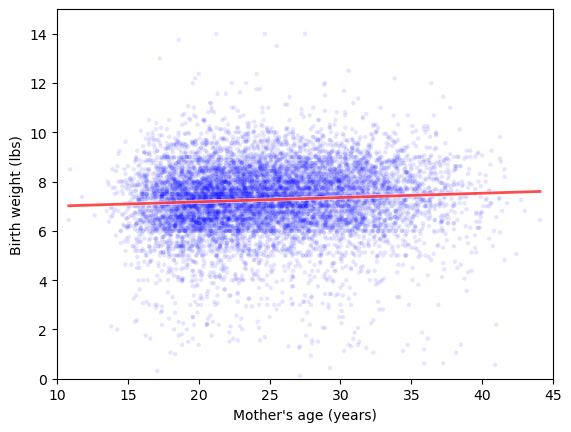

In [60]:
thinkplot.Scatter(ages, weights, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Birth weight (lbs)',
                 axis=[10, 45, 0, 15],
                 legend=False)

In [61]:
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

In [62]:
live['residual'] = Residuals(ages, weights, inter, slope)

In [63]:
bins = np.arange(10, 48, 3)
indices = np.digitize(live.agepreg, bins)
groups = live.groupby(indices)

age_means = [group.agepreg.mean() for _, group in groups][1:-1]
age_means

[15.212333333333335,
 17.740359281437126,
 20.506304824561404,
 23.455752212389378,
 26.435156146179406,
 29.411177432542924,
 32.30232530120482,
 35.240273631840786,
 38.10876470588235,
 40.91205882352941]

In [64]:
cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

In [65]:
def PlotPercentiles(age_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(age_means, weight_percentiles, label=label)

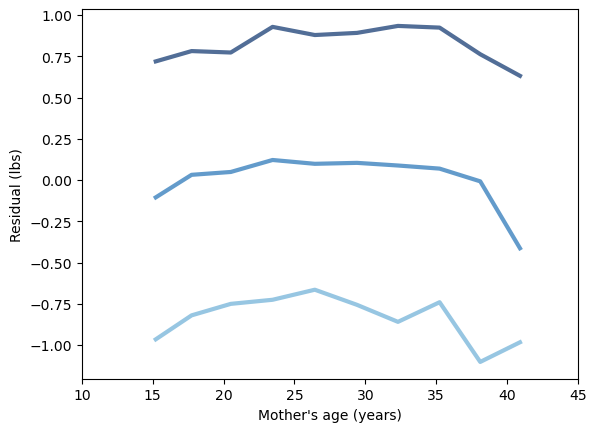

In [66]:
PlotPercentiles(age_means, cdfs)

thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

In [67]:
def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.

    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement

    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    """Resamples rows from a DataFrame.

    df: DataFrame

    returns: DataFrame
    """
    return SampleRows(df, len(df), replace=True)

In [68]:
def SamplingDistributions(live, iters=101):
    t = []
    for _ in range(iters):
        sample = ResampleRows(live)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = LeastSquares(ages, weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

In [69]:
inters, slopes = SamplingDistributions(live, iters=1001)

In [70]:
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

In [71]:
Summarize(inters)

mean, SE, CI 6.833391564956272 0.07393454995339452 (6.713699120105768, 6.9532179056421715)


In [72]:
Summarize(slopes)

mean, SE, CI 0.01734473807177455 0.0029039752152959196 (0.012550494293415124, 0.022038702550865964)


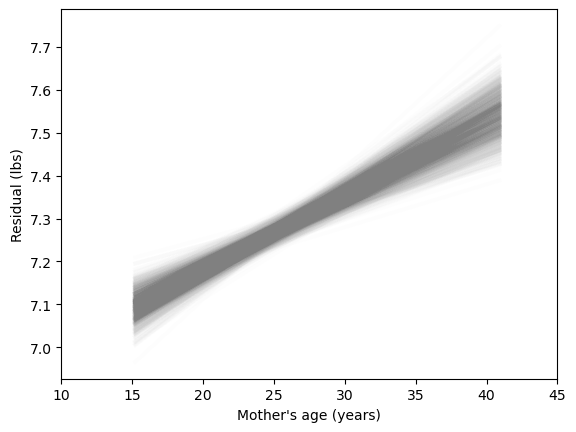

In [73]:
for slope, inter in zip(slopes, inters):
    fxs, fys = FitLine(age_means, inter, slope)
    thinkplot.Plot(fxs, fys, color='gray', alpha=0.01)
    
thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

In [74]:
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = FitLine(xs, inter, slope)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)

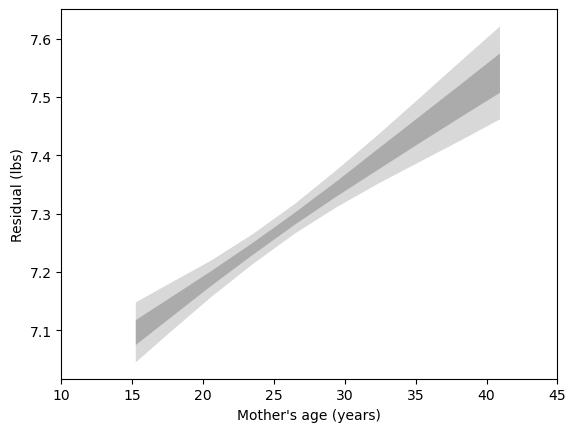

In [75]:
PlotConfidenceIntervals(age_means, inters, slopes, percent=90, 
                        color='gray', alpha=0.3, label='90% CI')
PlotConfidenceIntervals(age_means, inters, slopes, percent=50,
                        color='gray', alpha=0.5, label='50% CI')

thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

In [76]:
def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

In [77]:
inter, slope = LeastSquares(ages, weights)
res = Residuals(ages, weights, inter, slope)
r2 = CoefDetermination(weights, res)
r2

0.004738115474710369

In [78]:
print('rho', thinkstats2.Corr(ages, weights))
print('R', np.sqrt(r2))    

rho 0.06883397035410908
R 0.0688339703541091


In [79]:
print('Std(ys)', Std(weights))
print('Std(res)', Std(res))

Std(ys) 1.40821553384062
Std(res) 1.4048754287857834


In [80]:
var_ys = 15**2
rho = 0.72
r2 = rho**2
var_res = (1 - r2) * var_ys
std_res = np.sqrt(var_res)
std_res

10.409610943738484

In [81]:
class SlopeTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        ages, weights = data
        _, slope = thinkstats2.LeastSquares(ages, weights)
        return slope

    def MakeModel(self):
        _, weights = self.data
        self.ybar = weights.mean()
        self.res = weights - self.ybar

    def RunModel(self):
        ages, _ = self.data
        weights = self.ybar + np.random.permutation(self.res)
        return ages, weights

In [82]:
ht = SlopeTest((ages, weights))
pvalue = ht.PValue()
pvalue

0.0

In [83]:
ht.actual, ht.MaxTestStat()

(0.01745385147180276, 0.008782890737269415)

In [84]:
sampling_cdf = thinkstats2.Cdf(slopes)

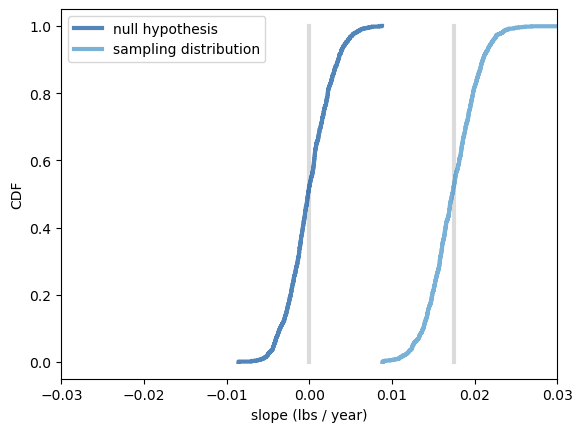

In [85]:
thinkplot.PrePlot(2)
thinkplot.Plot([0, 0], [0, 1], color='0.8')
ht.PlotCdf(label='null hypothesis')

thinkplot.Cdf(sampling_cdf, label='sampling distribution')

thinkplot.Config(xlabel='slope (lbs / year)',
                   ylabel='CDF',
                   xlim=[-0.03, 0.03],
                   legend=True, loc='upper left')

In [86]:
pvalue = sampling_cdf[0]
pvalue

0

In [87]:
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

In [88]:
iters = 100
estimates = [ResampleRowsWeighted(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.351499087187432 0.0149287967767085 (7.325120325293207, 7.375421830050896)


In [89]:
estimates = [thinkstats2.ResampleRows(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.268156602677584 0.013442665616405097 (7.244239599468909, 7.29003927860146)


# Exercises

**Exercise:** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

In [90]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [113]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
print(df.columns)
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

Index(['age', 'sex', 'wtyrago', 'finalwt', 'wtkg2', 'htm3'], dtype='object')


c:\Users\champ\OneDrive\Documents\DSC530 Data Exploration\ThinkStats2\code\brfss.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.age.replace([7, 9], float('NaN'), inplace=True)
c:\Users\champ\OneDrive\Documents\DSC530 Data Exploration\ThinkStats2\code\brfss.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

In [109]:
import thinkstats2

Least_Squares = LeastSquares(heights, log_weights)

r = thinkstats2.Corr(heights, log_weights)
r_squared = r**2


print(f"Least-Squared: {Least_Squares}")
print(f"R-Squared: {r_squared}")


#For every 1 cm increase in height, there is an increase of .0052 logrithmic weight. 

#It would be weakly helpful to know height, as height explains about 28% of log(weight).

Least-Squared: (0.9930804163932879, 0.0052814541694177755)
R-Squared: 0.2827349431189391


In [ ]:
import numpy as np
import pandas as pd
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'finalwt'])

heights = df['htm3']
weights = df['finalwt']

n = len(heights)
num_resamples = 200
means_no_weights = []
for _ in range(num_resamples):
    resample = np.random.choice(heights, size=n, replace=True)
    means_no_weights.append(np.mean(resample))
means_no_weights = np.array(means_no_weights)
mean_no_weights = np.mean(means_no_weights)
se_no_weights = np.std(means_no_weights)
ci_90_no_weights = np.percentile(means_no_weights, [5, 95])

means_with_weights = []
for _ in range(num_resamples):
    resample_indices = np.random.choice(np.arange(n), size=n, replace=True, p=weights/weights.sum())
    resample = heights.iloc[resample_indices]
    means_with_weights.append(np.mean(resample))
means_with_weights = np.array(means_with_weights)
mean_with_weights = np.mean(means_with_weights)
se_with_weights = np.std(means_with_weights)
ci_90_with_weights = np.percentile(means_with_weights, [5, 95])

print(f"Mean height (no weights): {mean_no_weights}")
print(f"Standard error (no weights): {se_no_weights}")
print(f"90% Confidence Interval (no weights): {ci_90_no_weights}")
print(f"Mean height (with weights): {mean_with_weights}")
print(f"Standard error (with weights): {se_with_weights}")
print(f"90% Confidence Interval (with weights): {ci_90_with_weights}")


#Correct weighting has a large effect on the estimates. It shift the mean upward, and it produces a much narrow Confidence Interval.
#Correct weighting is essential to reduce the bias of the model and shift the mean toward the true population mean.


c:\Users\champ\OneDrive\Documents\DSC530 Data Exploration\ThinkStats2\code\brfss.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.age.replace([7, 9], float('NaN'), inplace=True)
c:\Users\champ\OneDrive\Documents\DSC530 Data Exploration\ThinkStats2\code\brfss.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

Mean height (no weights): 168.82618337981418
Standard error (no weights): 0.01624390213249341
90% Confidence Interval (no weights): [168.79872681 168.85293526]
Mean height (with weights): 170.3686366158351
Standard error (with weights): 0.015995381674398262
90% Confidence Interval (with weights): [170.34119312 170.39438722]
